# Predicting NBA All-Star Appearances with Player Measurements

Scouts have mentioned taking a closer look at player wingspan when drafting prospects. Kevin Durant admitted his long wingspan helped him on defense. Draymond Green and Rudy Gobert admitted their long wingspan helped them stay in the league for their excellent defense. The Milwaukee Bucks used wingspan to draft Thon Maker, but traded him in 2019 as Maker couldn't break out into a defensive stud. But this raises an interesting question: can wingspan predict All-Star appearances? 

Data was extracted using the NBA_Measurements_Value_Scraper. Both Selenium and Beautiful Soup were used to extract data, with multhreading used to speed up the process. The values are stored in a csv file called NBA_Measurements_Value_Added.csv. For this analysis, we'll read from this file.

## Data Extraction and Cleaning

In [2]:
import pandas as pd
import numpy as np

In [3]:
NBA_MVA_df = pd.read_csv("NBA_Measurements_Value_Added.csv").dropna()
NBA_MVA_df = NBA_MVA_df.drop(['Unnamed: 0'], axis=1)
NBA_MVA_df = NBA_MVA_df[NBA_MVA_df.WINGSPAN > 50]
NBA_MVA_df = NBA_MVA_df[NBA_MVA_df.WEIGHT != '-']
NBA_MVA_df['WEIGHT'] = pd.to_numeric(NBA_MVA_df['WEIGHT'] , downcast='float')
NBA_MVA_df = NBA_MVA_df[NBA_MVA_df.WEIGHT > 0]


NBA_MVA_df['STANDING REACH'] = pd.to_numeric(NBA_MVA_df['STANDING REACH'] , downcast='float')
NBA_MVA_df['HEIGHT'] = pd.to_numeric(NBA_MVA_df['HEIGHT'] , downcast='float')
NBA_MVA_df['VA'] = pd.to_numeric(NBA_MVA_df['VA'] , downcast='float')
NBA_MVA_df['WINGSPAN'] = pd.to_numeric(NBA_MVA_df['WINGSPAN'] , downcast='float')


NBA_MVA_df= NBA_MVA_df.reset_index()
NBA_MVA_df = NBA_MVA_df.drop(['index'], axis=1)

In [4]:
NBA_MVA_df.head(15)

,PLAYER,VA,ALL-STAR,BODY FAT,HEIGHT,STANDING REACH,WEIGHT,WINGSPAN
0,James Harden,675.200012,1,10.10%,76.00,103.50,222.000000,82.75
1,Anthony Davis,508.500000,1,7.90%,81.25,108.00,221.800003,89.50
2,Nikola Vucevic,493.100006,1,6.10%,82.25,112.50,259.799988,88.50
3,Kevin Durant,485.100006,1,6.60%,81.00,110.00,215.000000,88.75
4,Paul George,479.600006,1,5.00%,79.75,107.00,214.399994,83.25
5,Damian Lillard,449.200012,1,5.90%,73.75,95.50,188.800003,79.75
6,Rudy Gobert,435.299988,0,4.40%,84.50,115.00,237.600006,92.50
7,LeBron James,409.299988,1,6.70%,79.25,106.25,245.000000,84.25
8,LaMarcus Aldridge,402.399994,1,8.70%,82.00,110.00,234.000000,88.75
9,Kawhi Leonard,401.200012,1,5.40%,78.00,106.00,227.399994,87.00


In [5]:
NBA_MVA_df['ALL-STAR'].value_counts()

0    186
1     38
Name: ALL-STAR, dtype: int64

Class imbalance

In [6]:
NBA_MVA_df.shape

(224, 8)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


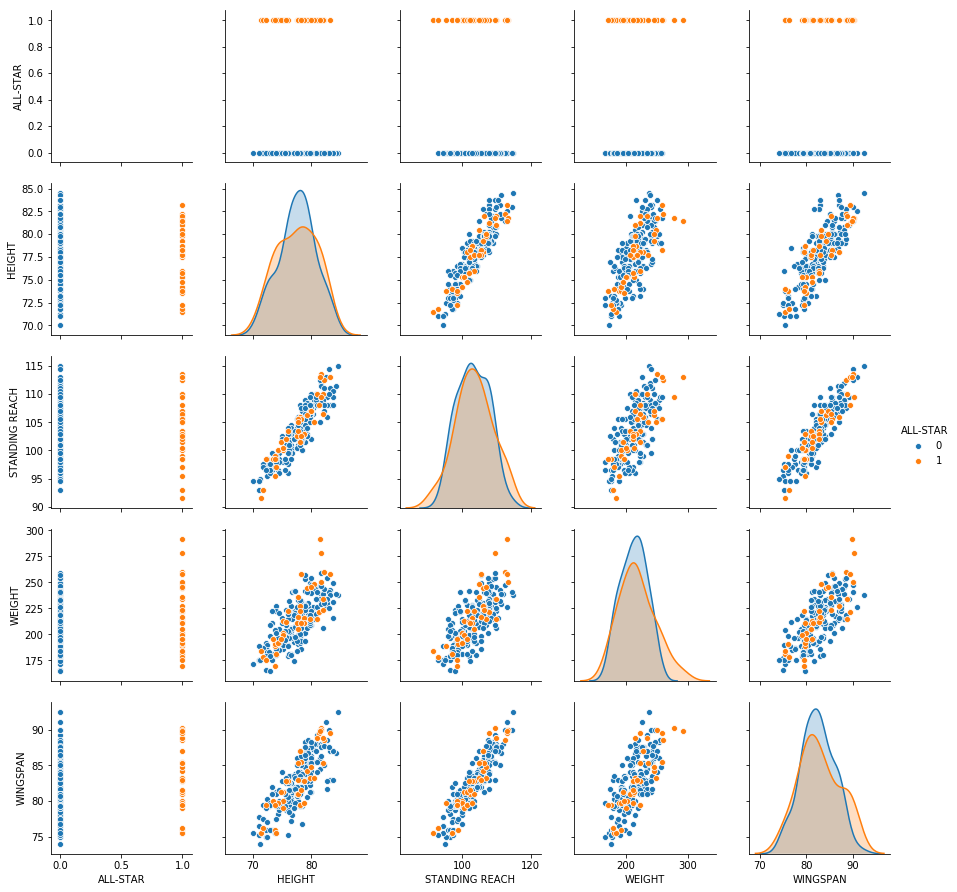

In [8]:
sns.pairplot(NBA_MVA_df[['ALL-STAR', 'HEIGHT', 'STANDING REACH', 'WEIGHT', 'WINGSPAN']], hue="ALL-STAR")

If we look at the KDE plots for Height, Standing Reach, Weight, and Wing Span, All-Stars and non All-Stars share very similar statistics. It would be very difficult to select a classification algorithm to predict an All-Star based on body measurements. There doesn't seem to be a strong difference between All-Stars and regular players on body measurements. 

We will attempt to do so using two methods

    1) Use Random Forest Classification to predict All-Stars based on Wingspan and Height. Bob Meyers once said that the perfect NBA player must be 6ft 8 inches tall with a 7ft 6 inches wingspan (assuming the player can score).
    
    2) Use PCA to map Height, Standing Reach, Weight, and WingSpan to 2 components. Use Random Forest Classification to predict All-Stars based on all those measurements. 


## Random Forest Classification with Wingspan and Height

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss, classification_report 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler 

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, label_train, label_test = train_test_split(NBA_MVA_df[['WINGSPAN', 'HEIGHT']], NBA_MVA_df['ALL-STAR'], test_size = 0.25, random_state = 0)



In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hdeva/anaconda3/l



Train Model: Logistic
Accuracy: 0.8511904761904762
Precision: 0.7245252267573695
Recall: 0.8511904761904762
F1: 0.7827668044709843
Log-Loss: 0.4145269013613224


Test Model: Logistic
Accuracy: 0.7678571428571429
Precision: 0.5896045918367347
Recall: 0.7678571428571429
F1: 0.6670274170274171
Log-Loss: 0.5721835973481263


Train Model: NB
Accuracy: 0.8511904761904762
Precision: 0.7245252267573695
Recall: 0.8511904761904762
F1: 0.7827668044709843
Log-Loss: 0.412981520168465


Test Model: NB
Accuracy: 0.7678571428571429
Precision: 0.5896045918367347
Recall: 0.7678571428571429
F1: 0.6670274170274171
Log-Loss: 0.562434982316914


Train Model: SVC
Accuracy: 0.8511904761904762
Precision: 0.7245252267573695
Recall: 0.8511904761904762
F1: 0.7827668044709843
Log-Loss: 0.42083107572444556


Test Model: SVC
Accuracy: 0.7678571428571429
Precision: 0.5896045918367347
Recall: 0.7678571428571429
F1: 0.6670274170274171
Log-Loss: 0.5658659251665402


Train Model: Decision Tree
Accuracy: 0.9761904761904

Text(0.5, 1.0, 'ROC curve')

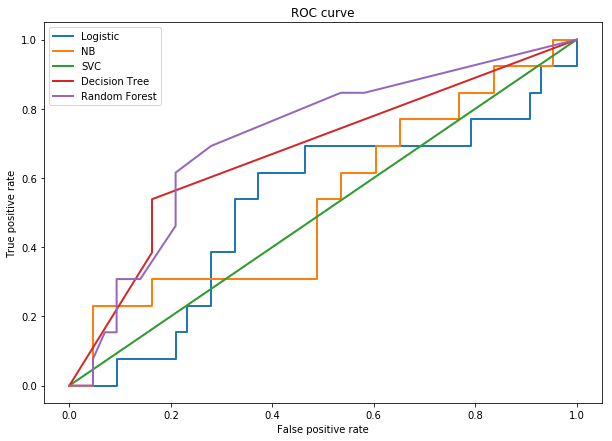

In [12]:
models = {
    "Logistic": [ LogisticRegression(solver='lbfgs', random_state = 4444), X_train, X_test] ,
    "NB": [ GaussianNB(), X_train, X_test] ,
    "SVC": [ OneVsRestClassifier(SVC(random_state = 4444, probability=True)), X_train_scaled, X_test_scaled],
    "Decision Tree": [ DecisionTreeClassifier(random_state=4444), X_train, X_test] ,
    "Random Forest": [ RandomForestClassifier(random_state=4444), X_train, X_test]
}

for key in models.keys():
    model_fit = models[key][0].fit(models[key][1], label_train)
    model_accuracy = accuracy_score(label_train, models[key][0].predict(models[key][1]))
    model_precision = precision_score(label_train, models[key][0].predict(models[key][1]), average='weighted')
    model_recall = recall_score(label_train, models[key][0].predict(models[key][1]), average='weighted')
    model_f1 = f1_score(label_train, models[key][0].predict(models[key][1]), average='weighted')        
    model_log_loss = log_loss(label_train, models[key][0].predict_proba(models[key][1]))
    print("\n\nTrain Model: " + str(key) + "\nAccuracy: " + str(model_accuracy) + "\nPrecision: " + str(model_precision)
          + "\nRecall: "+ str(model_recall) + "\nF1: " + str(model_f1) + "\nLog-Loss: " + str(model_log_loss)) 
    
    
    model_fit = models[key][0].fit(models[key][1], label_train)
    model_accuracy = accuracy_score(label_test, models[key][0].predict(models[key][2]))
    model_precision = precision_score(label_test, models[key][0].predict(models[key][2]), average='weighted')
    model_recall = recall_score(label_test, models[key][0].predict(models[key][2]), average='weighted')
    model_f1 = f1_score(label_test, models[key][0].predict(models[key][2]), average='weighted')        
    model_log_loss = log_loss(label_test, models[key][0].predict_proba(models[key][2]))
    print("\n\nTest Model: " + str(key) + "\nAccuracy: " + str(model_accuracy) + "\nPrecision: " + str(model_precision)
        + "\nRecall: "+ str(model_recall) + "\nF1: " + str(model_f1) + "\nLog-Loss: " + str(model_log_loss)) 
    
plt.figure(figsize = (10,7))
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


for key in models.keys():
    fpr, tpr, thresholds = roc_curve(label_test, models[key][0].predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr,lw=2, label=key) 
    #print('\nFalse Positive Rates: ', fpr)
    #print('\nTrue Positive Rates: ', tpr)
    #print('\nThreshold Levels: ', thresholds)
    print("\nROC AUC score for " + key +  " = " + str(roc_auc_score(label_test, models[key][0].predict_proba(X_test)[:, 1])))

plt.legend(loc=0)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

All models are prone to overfitting, especially decision trees and random forest. Yet, the random forest AUC score is the best, so we'll stick with that.

One reason why is that we have such limited data to work with (200 rows). Hence, the overfitting happens. Wingspan and Height data go back to 2003, so we have very little to work with. 

In [13]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(NBA_MVA_df[['WINGSPAN', 'HEIGHT']], NBA_MVA_df['ALL-STAR'], test_size = 0.25, random_state = 0)

# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


(0.7303571428571428, 0.7678571428571429, 0.733830544102191, None)


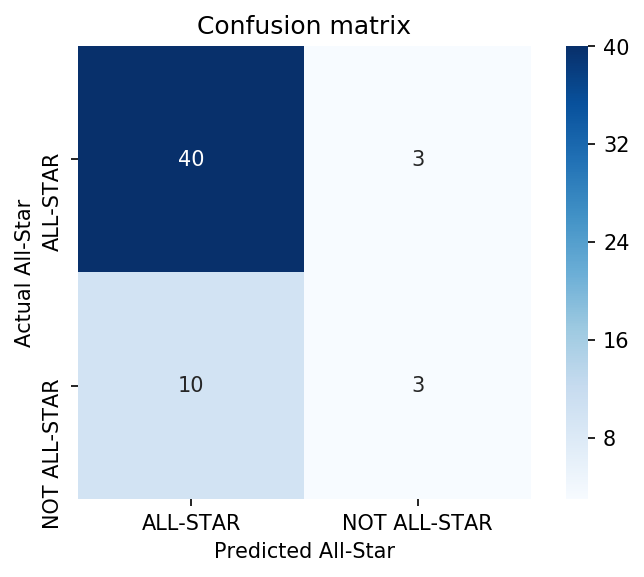

In [14]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(dpi=150)
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['ALL-STAR', 'NOT ALL-STAR'],
           yticklabels=['ALL-STAR', 'NOT ALL-STAR'])

plt.xlabel('Predicted All-Star')
plt.ylabel('Actual All-Star')
plt.title('Confusion matrix');


from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

The f1 score isn't good. 

What we predicted all star turned out not to be all star. This is an example of a False positive. We'd want to increase the threshold so to increase our precision score. 

(0.7303571428571428, 0.7678571428571429, 0.733830544102191, None)


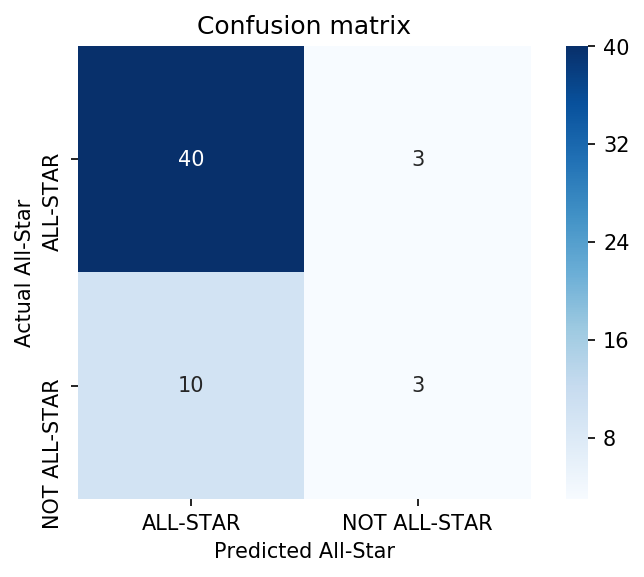

In [28]:
threshold = 0.60
y_predict = (classifier.predict_proba(X_test)[:, 1] >= threshold)

cm = confusion_matrix(y_test, y_predict)

plt.figure(dpi=150)
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['ALL-STAR', 'NOT ALL-STAR'],
           yticklabels=['ALL-STAR', 'NOT ALL-STAR'])

plt.xlabel('Predicted All-Star')
plt.ylabel('Actual All-Star')
plt.title('Confusion matrix');


from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, y_predict, average='weighted'))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


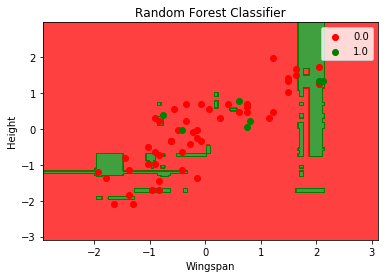

In [11]:
# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classifier')
plt.xlabel('Wingspan')
plt.ylabel('Height')
plt.legend()
plt.show()

Is Bob Meyers right? That the perfect NBA player must be 6ft 8 inches tall with a 7ft 6 inches wingspan? Let's use the Random Forest Classifier and predict whether an All-Star is from those measurements. 

In [30]:
#Predict Ideal Measurements : 6ft 8 inches  height with a 7ft 6 inches wingspan
print(classifier.predict([[90,80]]))

[1]


All Stars are 1 by our classifier. So Bob Meyers is right by our model. 

## PCA + Decision Tree Classifier on Weight, Standing Reach, Height and Wingspan

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = NBA_MVA_df.loc[:, ['HEIGHT', 'STANDING REACH', 'WEIGHT', 'WINGSPAN']].values
X = sc.fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponent = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponent, columns = ['PCA1', 'PCA2'])
principalDf = pd.concat([principalDf, NBA_MVA_df.loc[:,['ALL-STAR']]], axis=1)

In [16]:
principalDf.head(20)

,PCA1,PCA2,ALL-STAR
0,4.235525,-1.029130,0.0
1,-1.836642,-0.342397,0.0
2,-3.567413,-0.484809,0.0
3,-0.309569,-0.235592,1.0
4,0.248654,0.029057,1.0
5,-2.779687,0.118350,0.0
6,0.410834,0.124235,0.0
7,-0.681190,-0.093139,0.0
8,-3.088802,-0.270781,0.0
9,0.390430,-0.405484,0.0


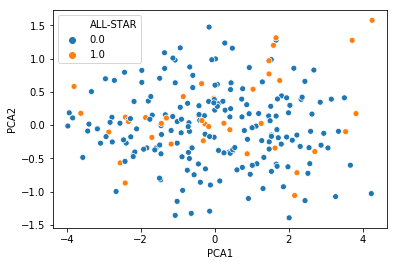

In [17]:
sns.scatterplot(x="PCA1", y="PCA2", hue="ALL-STAR", data=principalDf)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  import sys
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoid

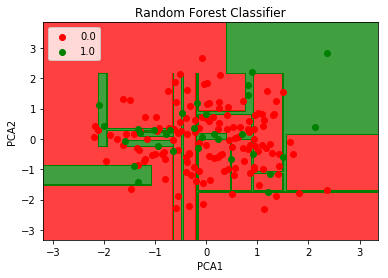

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


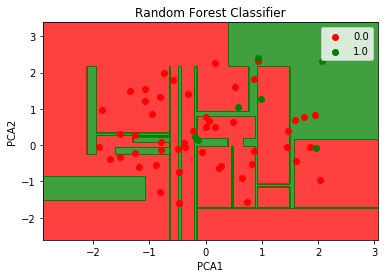

In [20]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(principalDf[['PCA1', 'PCA2']], principalDf['ALL-STAR'], test_size = 0.25, random_state = 0)

# Feature Scaling
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classifier')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classifier')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

## Conclusion

We have created two classification models. One that uses Wingspan and Height to predict All-Star selection. Another that uses Wingspan, Height, Standing Reach, and Weight to predict All-Star selection. 

Notice we do have a lot of false negatives. This is expected, as we took in all All-Star selections in NBA History. So players like Kyle Korver or Jeff Teague are playing average or below right now. But they made the All-Stars in 2015, so that was included in this data set. This data was included because we want to take into account all players' wingspans and measurements in the all-star selection. 